<h3>Introduction</h3>

<h5>Background</h5>
Gaming has become a significant part of many people’s lives, experiencing tremendous growth over the past decade. At the University of British Columbia, a research project has been established to explore how video game data can advance artificial intelligence (Wood et al, 2024). Professor Frank Wood founded the Pacific Laboratory for Artificial Intelligence also known as (PLAI) which is a research project using data collected from a Minecraft server to understand how people play video games (Wood et al, 2024). Their goal is to analyze how players interact with the game seeking insight to optimize recruiting efforts and resource allocation (Wood et al, 2024). PLAI looks to use this data to advance artificial intelligence through generative modeling, reinforcement learning, probabilistic programming and Bayesian inference to develop a safe and reliable AI (Wood et al, 2024).

<h5>Question</h5>
How well can we predict whether a player subscribes to a game-related newsletter based on their age and playtime (played hours)?

<h5>Data Description</h5>
For this data analysis we used the player.csv dataset which records user data from a Minecraft server. It contains 195 observations and 7 variables that details a user's profile and activity. The dataset contains categorical variables such as experience which consists of 5 different classes, Pro, Veteran, Amateur, Beginner and Regular and Gender which is split into , male, female, Agender, non binary, two-spirited, other and prefer not to say. A boolean variable subscribed indicates whether a user is subscribed or not. Numerical variables include played hours and age. String variables include name and hashed email which stores the user's email anonymously.



<h3>Methods and Results</h3>

<h5>Loading Packages</h5>
First we imported the package tidyverse and any other packages we needed for the predictive model into Jupyter.  


In [1]:
install.packages("tidyverse")
library(ggplot2)
library(tidyverse)
library(tidymodels)
library(gridExtra)
install.packages("kknn")
options(repr.matrix.max.rows=10)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ─

<h5>Loading, Wrangling and Cleaning the Data</h5>

We loaded the player data from a GitHub raw URL using "read_csv". We used the mutate function in R to convert the data set’s column played hours and age as numeric and subscribe as a factor. Then we used drop_na to remove any NA valued observations. 



In [2]:

url <- "https://raw.githubusercontent.com/Liam-ma06/DSCI_Project_final_report/refs/heads/main/players.csv"

player <- read_csv(url, show_col_types=FALSE) |>
    mutate(Age=as.numeric(Age))|>
    mutate(played_hours=as.numeric(played_hours))|>
    mutate(subscribe=as_factor(subscribe))|>
    drop_na(Age, played_hours, subscribe)


<h5>Data Set Proportions</h5>

We used "group_by" and "summarize" to find the percentages of subscribed and unsubscribed in the player.csv dataset. We will do this again to see if our proportions are preserved when we split the data.


In [3]:
player_proportions <- player|>
    group_by(subscribe)|>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(player))
player_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,52,26.80412
TRUE,142,73.19588


<h5>Dataset Graph</h5>

The code creates a scatter plot with "ggplot" that visualizes the relationship between Age and played_hours, with points colored based on the subscribe status. The "geom_point" function adds the data points to the plot, and "alpha=0.5" makes the points semi-transparent to improve readability. The "labs" function sets the axis labels and legend title. "scale_color_manual" customizes the colors of the points for the two subscription categories (darkorange for one group and steelblue for the other). Finally, "theme(text = element_text(size = 12))" adjusts the font size of the text elements in the plot.

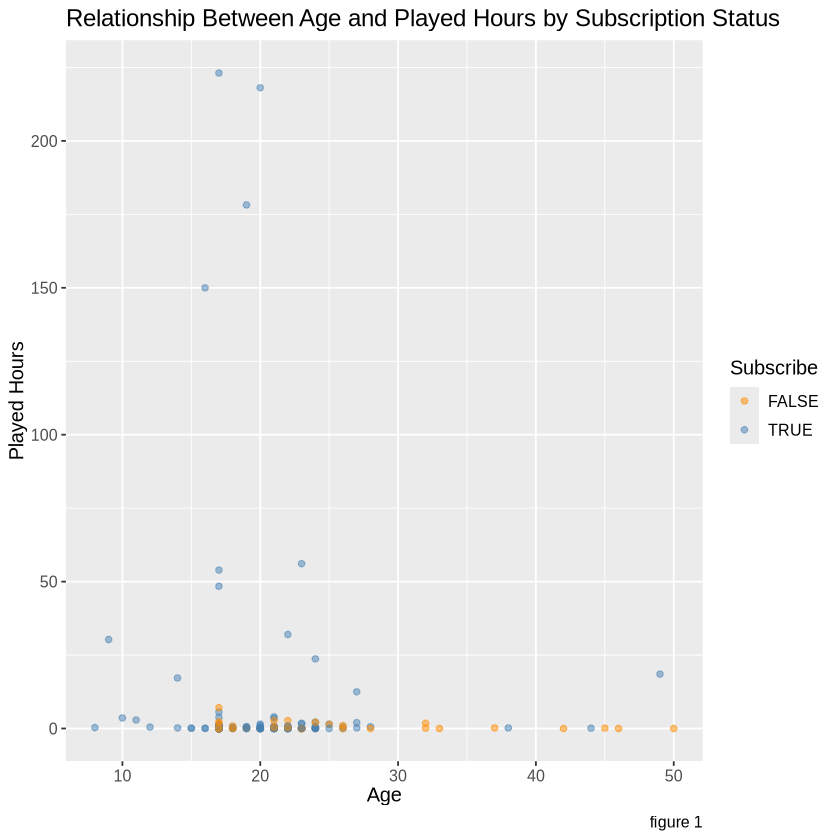

In [4]:
player_graph <- player|>
    ggplot(aes(x=Age, y=played_hours, color=subscribe))+
    geom_point(alpha=0.5)+
    labs(x="Age", y="Played Hours", color="Subscribe", title="Relationship Between Age and Played Hours by Subscription Status", caption = "figure 1")+
    scale_color_manual(values = c("darkorange", "steelblue")) +
    theme(text = element_text(size = 12))
player_graph
    

figure 1: This graph suggests a trend where users with higher played hours are more likely to be subscribed, as most of the points representing high playtime are associated with subscribers. Additionally younger players are more likely to subscribe than older players. 

<h5>Splitting Data</h5>

Radndom seed for reproducibility. We split the dataset into training and testing sets using the "initial_split" function. It sets the proportion of data used for training to 75% (prop=0.75) and ensures that the split is stratified by the subscribe variable, meaning the proportion of subscribed and non-subscribed users is maintained in both the training and testing sets (strata=subscribe). After splitting, the "training" is used to extract the training set, and the "testing" extracts the testing set. This ensures that the model will be trained on a representative subset of the data and tested on a separate subset to evaluate its performance.

In [5]:
set.seed(334)
player_split <- initial_split(player, prop=0.75, strata=subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

<h5>Data Set Proportions</h5>

We used "group_by" and "summarize" to find the percentages of subscribed and unsubscribed in the player training dataset. As seen the proportions are preserved when we split the data with 73% being subscribed and 26% not being subscribed.

In [6]:
player_proportions1 <- player_train|>
    group_by(subscribe)|>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(player_train))
player_proportions1
    

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,39,26.89655
TRUE,106,73.10345


<h5>Tuning and Evaluating Knn Model</h5>

For predictive modelling for subscription for players, we decided to use k-Nearest Neighbors (knn) classification algorithm. We chose to use it because its simple yet effective for prediction categroical outcomes such as whether a player subscribes to the game-related newsletter. Knn classification categorizes data points based on the majority class of their nearest neighbors. Therfore to optimize the models performance we need to find the optimal k value. 

We first set a random seed for reproducibility. Then using our training data we use the "recipe" framework to stadardize our scaling and centering all our predictors. We then use "nearest_neighbor" creating a Knn model with the number of neighbors set to be tuned. To safeguard against overfitting and ensure balanced groups in each fold we implemented a 5 fold cross validation on the training set. This method divides the data into five subsets enabling a comprehensive evaluation of the model's performance across different subsets. Finally a workflow is created that combines the recipe and model, and the "tune_grid" function tests different values for the number of neighbors, from 1 to 50, using the cross-validation splits. The performance metrics for each tested combination are collected, allowing for the evaluation of the best model configuration.

In [7]:
set.seed(123)

player_recipe <- recipe(subscribe ~ Age + played_hours, data=player_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("classification")

player_vfold <- vfold_cv(player_train, v=5, strata=subscribe)

knn_results <- workflow()|>
    add_recipe(player_recipe)|>
    add_model(knn_tune)|>
    tune_grid(resamples = player_vfold, grid=tibble(neighbors=seq(from=1, to=50, by=2)))|>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5243842,5,0.02354247,Preprocessor1_Model01
1,roc_auc,binary,0.5541667,5,0.02189878,Preprocessor1_Model01
3,accuracy,binary,0.5864532,5,0.03306920,Preprocessor1_Model02
3,roc_auc,binary,0.5500425,5,0.03149988,Preprocessor1_Model02
5,accuracy,binary,0.5926765,5,0.03072204,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,roc_auc,binary,0.5406926,5,0.059761957,Preprocessor1_Model23
47,accuracy,binary,0.7311494,5,0.005037841,Preprocessor1_Model24
47,roc_auc,binary,0.5057437,5,0.060119525,Preprocessor1_Model24


<h5>Model Evaluation</h5>
Here we identify the number of neighbors (K) that gives the highest accuracy for the tuning results. First we "filter" to select only the rows in "knn_results" that represent accuracy scores ignoring other metrics such as precision or recall. Next we conver the columns to numeric using "mutate" ensuring the "mean" accuracy values and k values are treated as numbers for correct comparisons. Finally we find the best accuracy by "filter" returning the row where the accuracy is equal to the maximum accuracy achieved during tuning. When this is done we find k=23 has a 74% accuracy which is the greatest prediction accuracy during cross validation.

In [8]:
accuracies <- knn_results |>
    filter(.metric=="accuracy")|>
    mutate(mean=as.numeric(mean), neighbors=as.numeric(neighbors))

best_accuracy <- accuracies |>
  filter(mean == max(mean))
best_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
23,accuracy,binary,0.7449425,5,0.01293346,Preprocessor1_Model12


<h5>Model Evaluation Visualization</h5>

We can also create a visualization to evaluate the efficiency of our knn predictive model. We used "ggplot", "geom_point" and "geom_line" to create a plot that shows the number of neighbors on the x axis and the accuracy on the y axis. By scruitinising the Knn Accuracy vs. Number of Neighbors graph we can pinpoint the optimal k value that maximizes predictive performance withough comprimising the models efficiency.

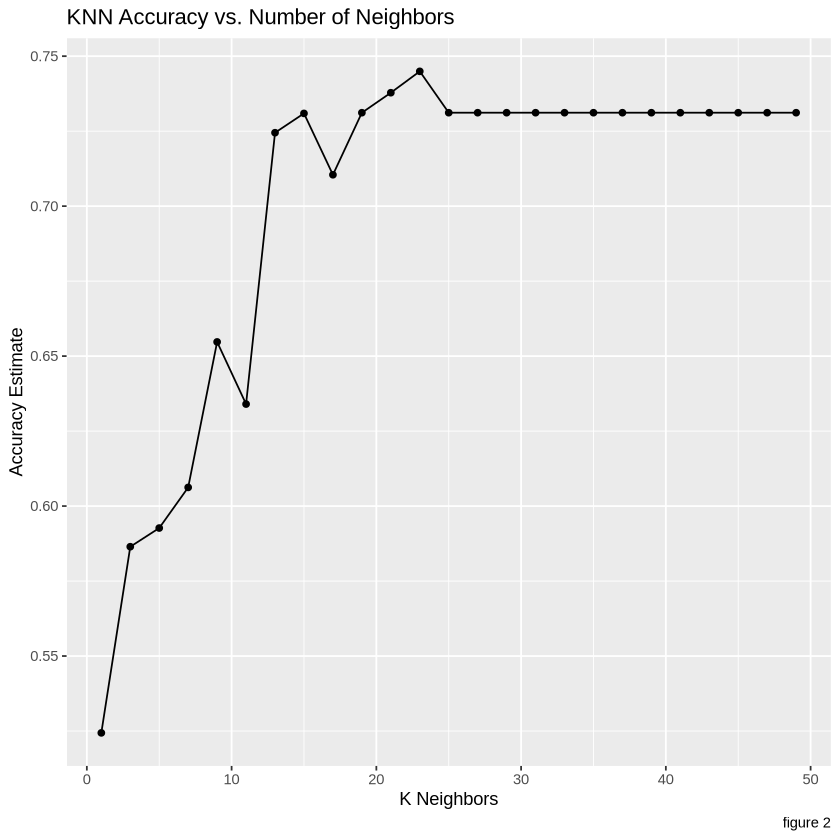

In [9]:
K_accuracy_plot <- accuracies |>
    ggplot(aes(x=neighbors, y=mean))+
    geom_point()+
    geom_line()+
    labs(x="K Neighbors", y="Accuracy Estimate", title="KNN Accuracy vs. Number of Neighbors", caption="figure 2")
K_accuracy_plot

figure 2: figure 2 shows when k=23 the classification model gives the highest accuracy therefore we will use this k value to perform the classification on the test data. As k increases from 1 to around 15 the accuracy improves significantly and peaks around k=23 with 74% accuracy. Beyond this point the accuracy stabilizes and shows only very minor fluctuations, maintaning around 73% accuracy. This graph suggests that small k values may lead to overfitting and therefore lower accuracy and increasing k further does not substantially affect accuracy.

<h5>Final Model Evaluation</h5>

Random seed for reproducibility. We create the final Knn classification model using 23 neighbors and evaluate its accuracy on the test data. We use the rectangular weighting function and set it up for classification using the "kknn" engine. We then create a workflow with this new model and fit the with our training data set. After training the model is used to make predictions on the test set. Finally, we calculate the accuracy of  the classification result on the testing data set.

In [10]:

set.seed(12345)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 23) |>
  set_engine("kknn") |>
  set_mode("classification")

# 2. Create the workflow
knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_train)


player_predictions <- knn_fit |>
  predict(player_test) |>
  bind_cols(player_test)


player_accuracy <- player_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy") |>
  select(.estimate) |>
  pull()


player_accuracy

[1] 0.7346939

<h5>Confusion Matrix</h5>

We can create a confusion matrix to help visualize our results better.



In [11]:
confusion_matrix <- player_predictions|>
    conf_mat(truth=subscribe, estimate=.pred_class)
confusion_matrix

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

figure 3: The confusion matrix shows that the model is very good at predicting subscribed users (36 true positives and no false positives), but struggles with non-subscribed users, incorrectly predicting 13 of them as subscribed (false negatives). This indicates a class imbalance, where the model is biased toward predicting the "TRUE" (subscribed) class, leading to low recall for the "FALSE" (non-subscribed) class. While overall accuracy may appear high, the model's performance is poor for predicting non-subscribed users, which could be a significant issue depending on the application.

<h3>Discussion</h3>

In this analysis, we explored whether players’ likelihood of subscribing could be predicted using their Age and Played Hours. After tuning a k-Nearest Neighbors (k-NN) classifier, we found that the best model (with k = 23) achieved an accuracy of approximately 73% on the test set. The model performed well in predicting subscribers (TRUE), but struggled to correctly classify non-subscribers (FALSE), as seen in the confusion matrix. While overall accuracy is useful, evaluating precision and recall gives us a deeper understanding of our model’s performance. In our case, Precision = True Positive / (True Positive + False Positive) = 36 / (36 + 13) = 0.73%, and Recall = True Positive / (True Positive + False Negative) = 36 / (36 + 0) = 1.0. These values show that our model is excellent at identifying users who are actually subscribed (high recall), and it also maintains a relatively strong precision score, meaning that most predicted subscribers were indeed correct. However, we should note that the model struggles with identifying non-subscribers, correctly predicting only 0 out of 13. This imbalance suggests the model may be biased toward predicting subscriptions, likely due to uneven class distribution in the training data. In future improvements, especially if the goal is to better identify unsubscribed users, we could explore resampling techniques or alternative models to balance performance. Nonetheless, within the scope of this study and using the current predictors (age and played hours), the model performs fairly well in identifying subscribers but is limited in recognizing non-subscribers.

The results were partly expected. It makes sense that played hours would be positively associated with a subscription—players who spend more time in the game are more likely to invest financially. However, the model’s difficulty in identifying non-subscribers was a bit surprising. This may be due to:
Class imbalance (more subscribers than non-subscribers),
Overlapping behavior patterns between light users who still subscribe and heavy users who don’t.

These results suggest that simple behavioral metrics like age and played time already carry meaningful signals about a user’s likelihood to subscribe. For game developers or marketing teams:
1) This model could be used to identify likely subscribers early on and personalize offers or trial extensions.
2) It could also help segment users for engagement strategies or early interventions for churn risk.

Future questions:
1) What other variables might improve predictive power?
2) How does the timing of subscriptions relate to player behavior?



<h3>References</h3>

Wood, F., et al. (2024, December 5). Pacific Laboratory for Artificial Intelligence. https://plai.cs.ubc.ca/